# Importing Libraries

In [1]:
import torch,torchvision
from torch import nn
from torch import optim 
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
numb_batch=64

# Getting Data

In [3]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

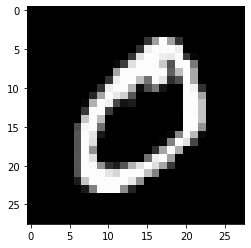

In [4]:
plt.imshow(train_data[1][0][0],cmap='gray')

# Creating the Model

In [5]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

# Validating the Model

In [6]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cpu()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

# Training Function

In [7]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return cnn

# GPU Availability

Now we check if a GPU is available. If so, then we can use it. If not, then we must resort to using the CPU.

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
    device

No Cuda Available


# Training the Model



Saving Best Model with Accuracy:  94.68000030517578
Epoch: 1 Accuracy : 94.68000030517578 %
Saving Best Model with Accuracy:  97.05999755859375
Epoch: 2 Accuracy : 97.05999755859375 %
Saving Best Model with Accuracy:  97.95999908447266
Epoch: 3 Accuracy : 97.95999908447266 %
Saving Best Model with Accuracy:  98.01000213623047
Epoch: 4 Accuracy : 98.01000213623047 %
Saving Best Model with Accuracy:  98.25
Epoch: 5 Accuracy : 98.25 %


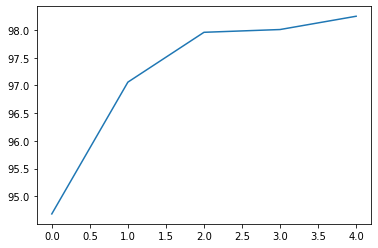

In [9]:
lenet = train(5, device=device)

# Saving the model

In [78]:
torch.save(lenet, "lenet.pth")

# Define Inference function to get prediction for any given image

In [81]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        inp_tensor = torch.unsqueeze(T(x), axis=0).float().to(device)
        pred = model(inp_tensor)
        print(pred)
        return F.softmax(pred, dim=-1).cpu().numpy()

# Getting the image from the web
We can simply just copy the image’s address from the internet and paste it in the string path. Then, we can access the contents of the image and resize it, similar to what we did in the inference function.


In [58]:
from bs4 import BeautifulSoup 
import requests 
from io import BytesIO
from PIL import Image 
import numpy as np

In [59]:
path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255

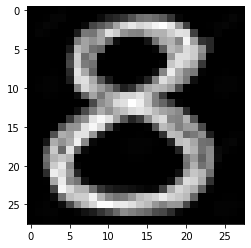

In [60]:
plt.imshow(x.squeeze(-1), cmap="gray")

# Predictions

In [ ]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")